# Here you need to add the paper title, and then a small block of general explanation for a binder

# Experiments on neuromuscular efficiency of respiratory muscles

Import libraries

In [1]:
import copy
import math
import collections
from scipy import interpolate as interp
import scipy
import pandas as pd
import glob
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from datetime import datetime
%matplotlib widget

# The cell below will need to be changed for a generalized binder

In [2]:
sys.path.insert(0, '../ReSurfEMG')
import helper_functions as hf
from config import Config
config = Config()

In [3]:
# get new changes in our library i.e. the tmsisdk
import sys
sys.path.insert(0, '../resurfemg')

from tmsisdk_lite import Poly5Reader

# Prepare an output folder for experiments

In [4]:
# Output data - General path to dir for saving .csvs and plots
main_output_dir = config.get_directory('preprocessed') + '/2023_03_rerun'
if not os.path.exists(main_output_dir):
    os.makedirs(main_output_dir)

The below cell allows you to pick whether to display and interact with the data in seconds or samples.

In [5]:
y_axis = widgets.Dropdown(
    options=["Samples", "Seconds"],
    value='Seconds',
    description="Select View Option",
    disabled=False,
)
display(y_axis)

Dropdown(description='Select View Option', index=1, options=('Samples', 'Seconds'), value='Seconds')

The below cell confirms your choice.

In [6]:
time_view = y_axis.value
time_view

'Seconds'

<a id='#patient_select'>Input patient file path</a>

In [7]:
# Root directory for patient data
root_patient_data_directory = config.get_directory('root_patient_data_directory')

patient_idx = 0

In [9]:
patient_folders = glob.glob(root_patient_data_directory + '/**/', recursive=False)
patients = []

for folder in patient_folders:
    name = folder.split("\\")[-2]
    patients.append(name)

btn_pt = widgets.Dropdown(
    options=patients,
    value=patients[patient_idx],
    description='Select patient:',
    disabled=False,
)

date_idx = 0

display(btn_pt)

Dropdown(description='Select patient:', options=('2022_09-16-Test_lung_data_respiratory_rate_22', 'MST001', 'M…

<a id='section_date_step'>Next date</a>

In [10]:
patient = btn_pt.value
patient_idx =btn_pt.index

measurement_folders = glob.glob(root_patient_data_directory + '/' + patient + '/**/', recursive=False)
measurements = []

for folder in measurement_folders:
    name = folder.split("\\")[-2]
    measurements.append(name)

btn_measurement = widgets.Dropdown(
    options=measurements,
    value=measurements[date_idx],
    description='Select measurement date:',
    disabled=False,
)
display(btn_measurement)

Dropdown(description='Select measurement date:', options=('2021-12-24_09-29-46', '2021-12-27_09-16-26', '2021-…

In [12]:
measurement = btn_measurement.value
date_idx = btn_measurement.index

# Input data
windows_str = root_patient_data_directory + '/' + patient + '/' + measurement
root_emg_directory = os.path.join(windows_str)

# do not rerun this cell
big_data_list = []

measurement_idx = 5

# Reruns should be done from this cell as the start

<a id='section_peep_step'>Next PEEP step</a>

Now you can pick a file from the list, which have been numbered.

In [13]:
emg_pattern = os.path.join(root_emg_directory, '**/*.Poly5')
emg_and_draeger_files = glob.glob(emg_pattern, recursive=True)

emg_files = []
draeger_files = []

for file in emg_and_draeger_files:
    if 'Draeger' in file:
        draeger_files.append(file)
    else:
        emg_files.append(file)
list_of_numbers_strung = []

for i in range(len(emg_files)):
    list_of_numbers_strung.append(str(i))


btn = widgets.Dropdown(
    options=list_of_numbers_strung,
    value=str(measurement_idx),
    description='Picked File:',
    disabled=False,
)
display(btn)

Dropdown(description='Picked File:', index=5, options=('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10')…

In [14]:
number_chosen = int(btn.value)
emg_file_chosen = emg_files[number_chosen]
draeger_file_chosen = draeger_files[number_chosen]
print("The files you chose are:\n", emg_file_chosen, '\n', draeger_file_chosen)

The files you chose are:
 P:/TNW/CRPH/Projects/2021_Warnaar_TOPSPIN_studie/4_Patient_data/1_RAW/MST001/2021-12-27_09-16-26\010\EMG_recording.Poly5 
 P:/TNW/CRPH/Projects/2021_Warnaar_TOPSPIN_studie/4_Patient_data/1_RAW/MST001/2021-12-27_09-16-26\010\Draeger_recording.Poly5


In [15]:
# get the poly5 reading
data_emg = Poly5Reader(emg_file_chosen)
data_draeger = Poly5Reader(draeger_file_chosen)
data_emg_samples = data_emg.samples[:data_emg.num_samples]
emg_sample_rate = data_emg.sample_rate
data_draeger_samples = data_draeger.samples[:data_draeger.num_samples]
draeger_sample_rate = data_draeger.sample_rate

# Output data path - Patient specific
patient = emg_files[number_chosen].split('\\')[-3].split('/')[-2]
measurement = emg_files[number_chosen].split('\\')[-2]

if not os.path.exists(main_output_dir + '/' + patient + '/'):
    os.makedirs(main_output_dir + '/' + patient + '/')

if not os.path.exists(main_output_dir + '/' + patient + '/' + measurements[date_idx] + '/'):
    os.makedirs(main_output_dir + '/' + patient + '/' + measurements[date_idx] + '/')

Reading file  P:/TNW/CRPH/Projects/2021_Warnaar_TOPSPIN_studie/4_Patient_data/1_RAW/MST001/2021-12-27_09-16-26\010\EMG_recording.Poly5
	 Number of samples:  719840 
	 Number of channels:  3 
	 Sample rate: 2048 Hz
Done reading data.
Reading file  P:/TNW/CRPH/Projects/2021_Warnaar_TOPSPIN_studie/4_Patient_data/1_RAW/MST001/2021-12-27_09-16-26\010\Draeger_recording.Poly5
	 Number of samples:  35142 
	 Number of channels:  3 
	 Sample rate: 100 Hz
Done reading data.


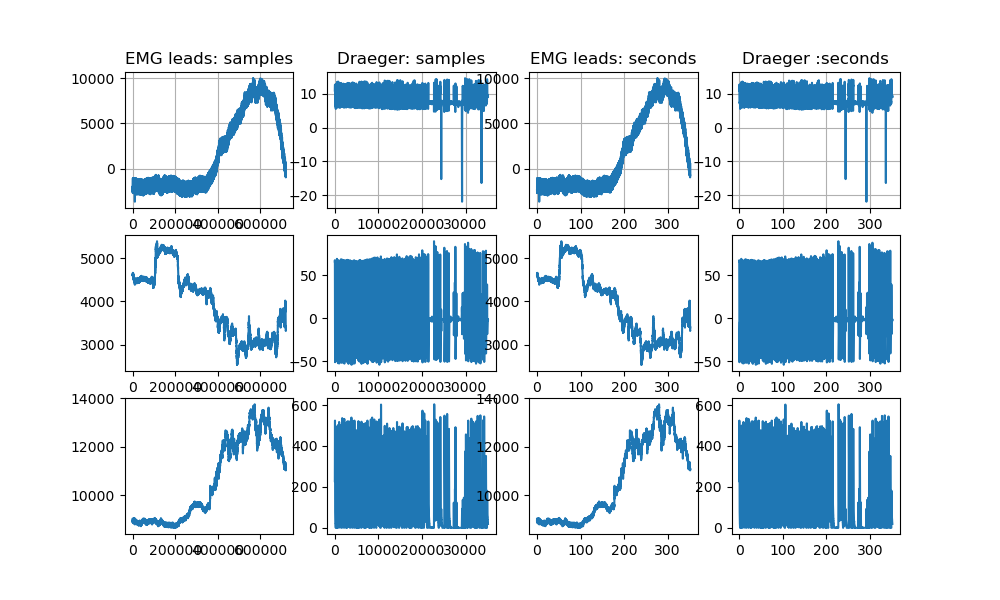

In [16]:
x_emg = data_emg_samples
x_draeger = data_draeger_samples

y_emg = [i/emg_sample_rate for i in range(len(x_emg[0, :]))]
y_draeger = [i/draeger_sample_rate for i in range(len(x_draeger[0, :]))]

fig, axis = plt.subplots(nrows=3, ncols=4, figsize=(10, 6))
axis[0, 0].grid(True)
axis[0, 0].plot(x_emg[0])
axis[0, 0].set(title='EMG leads: samples')
axis[1, 0].plot(x_emg[1])
axis[2, 0].plot(x_emg[2])

axis[0, 1].set(title='Draeger: samples')
axis[0, 1].grid(True)
axis[0, 1].plot(x_draeger[0])
axis[1, 1].plot(x_draeger[1])
axis[2, 1].plot(x_draeger[2])

axis[0, 2].grid(True)
axis[0, 2].plot(y_emg, x_emg[0])
axis[0, 2].set(title='EMG leads: seconds')
axis[1, 2].plot(y_emg, x_emg[1])
axis[2, 2].plot(y_emg, x_emg[2])

axis[0, 3].set(title='Draeger :seconds')
axis[0, 3].grid(True)
axis[0, 3].plot(y_draeger, x_draeger[0])
axis[1, 3].plot(y_draeger, x_draeger[1])
axis[2, 3].plot(y_draeger, x_draeger[2])

Here pick the part of the signal you want to look at. It is advised to never start at zero, or end after the signal, and the widgets have been constrained to do this.

In [17]:
start_widget = widgets.BoundedFloatText(
    value=np.floor(y_draeger[-1]-100),
    min=1,
    max=y_draeger[-1],
    step=1,
    description='Start:',
    disabled=False
)
end_widget = widgets.BoundedFloatText(
    value=np.floor(y_draeger[-1]-10),
    min=1,
    max=y_draeger[-1],
    step=1,
    description='End:',
    disabled=False
)
widgets.VBox([start_widget, end_widget])

In [18]:
start = start_widget.value
end = end_widget.value
if start >= end:
    print('Please choose logical values. You made a mistake.')

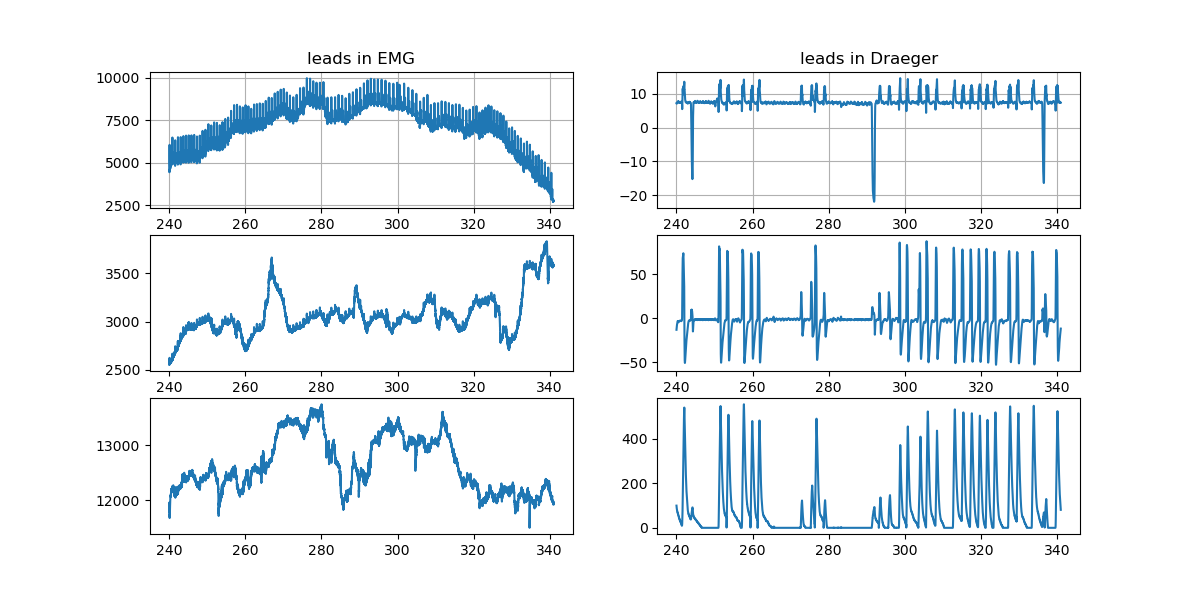

In [19]:
# now examine at the selected window to contain all occlusions

if time_view == 'Seconds':
    start_s = int(float(start)* emg_sample_rate)
    end_s = min([int(float(end)*emg_sample_rate), len(x_emg[0,:])-1])
    start_draeger_s = int(float(start)* draeger_sample_rate)
    end_draeger_s = min([int(float(end)* draeger_sample_rate), len(x_draeger[0,:])-1])

else:
    start_s = int(float(start))
    end_s = min([int(float(end)), len(data_emg_samples[0])-1])
    start_draeger_s = int(float(start)* draeger_sample_rate/emg_sample_rate)
    end_draeger_s = min([int(float(start)* draeger_sample_rate/emg_sample_rate), len(data_draeger_samples[0])-1])
    y_emg = [range(len(data_emg_samples[0]))]
    y_draeger = [range(len(data_draeger_samples[0]))]


fig, axis = plt.subplots(nrows=3, ncols=2, figsize=(12, 6))
axis[0, 0].set(title='leads in EMG')
axis[0, 0].grid(True)
axis[0, 0].plot(y_emg[int(start_s):int(end_s)], x_emg[0][int(start_s):int(end_s)])
axis[1, 0].plot(y_emg[int(start_s):int(end_s)], x_emg[1][int(start_s):int(end_s)])
axis[2, 0].plot(y_emg[int(start_s):int(end_s)], x_emg[2][int(start_s):int(end_s)])

axis[0, 1].set(title='leads in Draeger')
axis[0, 1].grid(True)
axis[0, 1].plot(
    y_draeger[int(start_draeger_s):int(end_draeger_s)], 
    x_draeger[0][int(start_draeger_s):int(end_draeger_s)]
)
axis[1, 1].plot(
    y_draeger[int(start_draeger_s):int(end_draeger_s)], 
    x_draeger[1][int(start_draeger_s):int(end_draeger_s)]
)
axis[2, 1].plot(
    y_draeger[int(start_draeger_s):int(end_draeger_s)], 
    x_draeger[2][int(start_draeger_s):int(end_draeger_s)]
)

Happy with your selection? If not redo

# Pre-processing pipeline

In [20]:
# Eliminate the baseline wander from the data
bd_filtered_file_data = hf.emg_bandpass_butter_sample(data_emg_samples, 1, 500, 2048, output='sos')
    
processed_data_emg_di = bd_filtered_file_data[1]
processed_data_emg_para = bd_filtered_file_data[2]

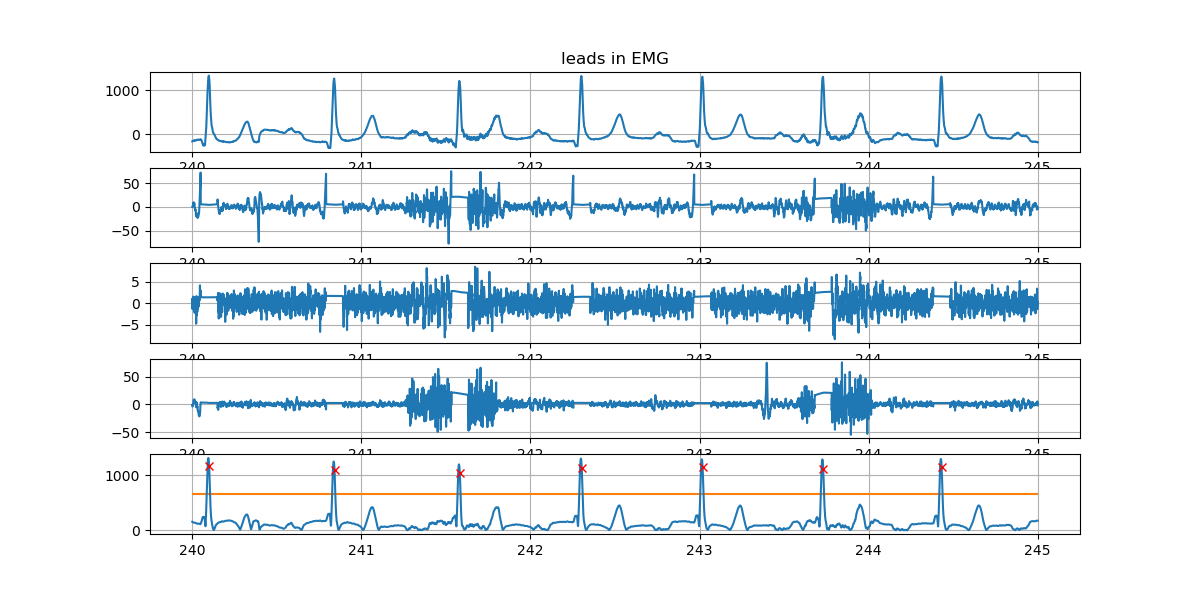

In [21]:
# Apply QRS gating
# Gating settings
plot_window = 5         # Window size to plot the gating results from
peak_fraction = 0.50    # Peak height fraction
ECG_shift = -10           # Shift of gated in samples relative to detected peaks
gate_width = 0.1        # Gate width in seconds

# Detect ECG peaks on 1Hz high-pass filtered signals
peak_width = 0.001
peak_dist = int(emg_sample_rate/3)

ecg = bd_filtered_file_data[0]
ecg_rms = hf.full_rolling_rms(ecg, 10)
max_ecg_rms = max(ecg_rms[int(start_s):int(start_s+plot_window*emg_sample_rate)])
min_ecg_rms = min(ecg_rms[int(start_s):int(start_s+plot_window*emg_sample_rate)])
peak_height = peak_fraction*(max_ecg_rms - min_ecg_rms)

ECG_peaks, properties  = scipy.signal.find_peaks(
    ecg_rms, 
    height=peak_height, 
    width=peak_width*emg_sample_rate, 
    distance=peak_dist
)
ECG_peaks = ECG_peaks - ECG_shift

# Filter EXG signals 20Hz high pass
ECG_h20 = hf.emg_bandpass_butter_sample(ecg, 20, 500, 2048, output='sos')
emg_di_h20 = hf.emg_bandpass_butter_sample(processed_data_emg_di, 20, 500, 2048, output='sos')
emg_para_h20 = hf.emg_bandpass_butter_sample(processed_data_emg_para, 20, 500, 2048, output='sos')

# Gate ECG and EMG signal
gate_fill_method = 3    # 0: Zeros, 1: Interpolate start-end, 2: Average prior data, 3: Moving average
gate_width_samples = int(gate_width*emg_sample_rate)

gate_samples = list()
for i in range(len(ECG_peaks)):
    for k in range(int(ECG_peaks[i]-gate_width_samples/2),int(ECG_peaks[i]+gate_width_samples/2)):
        gate_samples.append(k)

ECG_gated = hf.gating(ECG_h20, ECG_peaks, gate_width=gate_width_samples, method=3)
emg_di_gated = hf.gating(emg_di_h20, ECG_peaks, gate_width=gate_width_samples, method=3)
emg_para_gated = hf.gating(emg_para_h20, ECG_peaks, gate_width=gate_width_samples, method=3)

# Plot output data --------------------------------

fig, axis = plt.subplots(nrows=5, ncols=1, figsize=(12, 6))
start_i = int(start_s)
end_i = int(start_s+plot_window*2048)
axis[0].grid(True)
axis[0].plot(y_emg[start_i:end_i], bd_filtered_file_data[0, start_i:end_i])

axis[0].set(title='leads in EMG')
axis[1].grid(True)
axis[1].plot(y_emg[start_i:end_i], ECG_gated[start_i:end_i])
axis[2].grid(True)
axis[2].plot(y_emg[start_i:end_i], emg_di_gated[start_i:end_i])
axis[3].grid(True)
axis[3].plot(y_emg[start_i:end_i], emg_para_gated[start_i:end_i])

axis[4].grid(True)
axis[4].plot(y_emg[start_i:end_i], ecg_rms[start_i:end_i])
axis[4].hlines(
    y=peak_height, 
    xmin=y_emg[start_i], 
    xmax=y_emg[end_i],
    color = "C1"
)

for idx in range(len(ECG_peaks)):
    if (ECG_peaks[idx] > int(start_s)) & (ECG_peaks[idx] < int(start_s+plot_window*2048)):
        axis[4].plot(y_emg[ECG_peaks[idx]], ecg_rms[ECG_peaks[idx]],'rx')


# Calculate root mean squared (RMS)

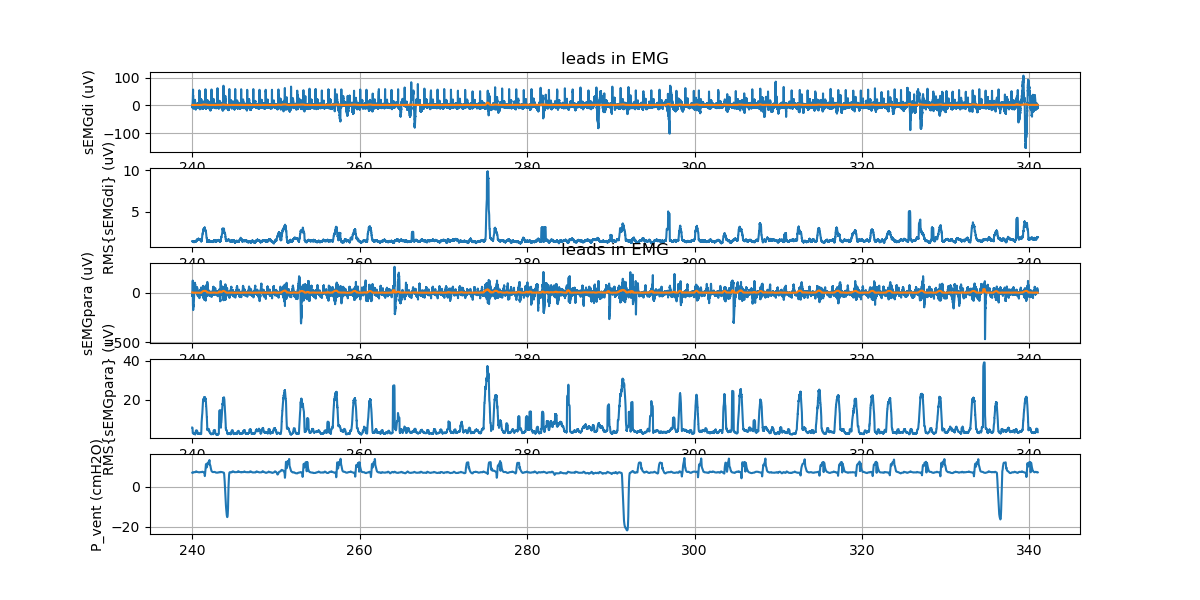

In [23]:
RMS_window_ms = 200
RMS_windows_samp = int(RMS_window_ms / 1000 *  emg_sample_rate)

RMS_data_emg_di = hf.full_rolling_rms(emg_di_gated, RMS_windows_samp)
RMS_data_emg_para = hf.full_rolling_rms(emg_para_gated, RMS_windows_samp)

fig, axis = plt.subplots(nrows=5, ncols=1, figsize=(12, 6))
axis[0].set(title='leads in EMG')
axis[0].set_ylabel('sEMGdi (uV)')
axis[0].grid(True)
axis[0].plot(y_emg[int(start_s):int(end_s)], processed_data_emg_di[int(start_s):int(end_s)])
axis[0].plot(y_emg[int(start_s):int(end_s)], RMS_data_emg_di[int(start_s):int(end_s)])

axis[1].set_xlabel('t (s)')
axis[1].set_ylabel('RMS{sEMGdi} (uV)')
axis[1].plot(y_emg[int(start_s):int(end_s)], RMS_data_emg_di[int(start_s):int(end_s)])

axis[2].set(title='leads in EMG')
axis[2].set_ylabel('sEMGpara (uV)')
axis[2].grid(True)
axis[2].plot(y_emg[int(start_s):int(end_s)], processed_data_emg_para[int(start_s):int(end_s)])
axis[2].plot(y_emg[int(start_s):int(end_s)], RMS_data_emg_para[int(start_s):int(end_s)])

axis[3].set_xlabel('t (s)')
axis[3].set_ylabel('RMS{sEMGpara} (uV)')
axis[3].plot(y_emg[int(start_s):int(end_s)], RMS_data_emg_para[int(start_s):int(end_s)])

axis[4].set_ylabel('P_vent (cmH2O)')
axis[4].grid(True)
axis[4].plot(
    y_draeger[int(start_draeger_s):int(end_draeger_s)], 
    x_draeger[0][int(start_draeger_s):int(end_draeger_s)]
)



Determine PEEP level

In [24]:
x = x_draeger[2][:int(start_draeger_s)]
V_ee_PKS, _ = scipy.signal.find_peaks(-x)

PEEP_set = np.floor(np.median(x_draeger[0, V_ee_PKS]))


PEEP_set

7.0

In [34]:
# Moving baseline on pressure and all EMG signals for baseline crossing detection

baseline_W_emg = 5 * emg_sample_rate  # window length
baseline_W_draeger = 5 * draeger_sample_rate  # window length

# emg_di_rolling_base_line = np.percentile(strided_app(RMS_data_emg[int(start_s):int(end_s)], W,1), 33, axis=-1)
emg_di_rolling_base_line = np.zeros(
    (len(RMS_data_emg_di[int(start_s):int(end_s)]), ))
emg_para_rolling_base_line = np.zeros(
    (len(RMS_data_emg_para[int(start_s):int(end_s)]), ))
P_rolling_base_line = np.zeros(
    (len(x_draeger[0, int(start_draeger_s):int(end_draeger_s)]), ))

for idx in range(0, int(end_s)-int(start_s), int(emg_sample_rate/5)):
    start_i = max([int(start_s), int(start_s)+idx-int(baseline_W_emg/2)])
    end_i = min([int(end_s), int(start_s)+idx+int(baseline_W_emg/2)])
    baseline_value_emg_di = np.percentile(
        RMS_data_emg_di[start_i:end_i], 33)
    baseline_value_emg_para = np.percentile(
        RMS_data_emg_para[start_i:end_i], 33)
    for i in range(idx, min([idx+int(emg_sample_rate/5), int(end_s)-int(start_s)])):
        emg_di_rolling_base_line[i] = baseline_value_emg_di
        emg_para_rolling_base_line[i] = baseline_value_emg_para

for idx in range(0, int(end_draeger_s)-int(start_draeger_s), int(draeger_sample_rate/5)):
    start_i = max([int(start_draeger_s), int(
        start_draeger_s)+idx-int(baseline_W_draeger/2)])
    end_i = min([int(end_draeger_s), int(start_draeger_s) +
                idx+int(baseline_W_draeger/2)])
    P_rolling_base_line[idx] = np.percentile(x_draeger[0, start_i:end_i], 33)

    baseline_value_P = np.percentile(x_draeger[0, start_i:end_i], 33)
    for i in range(idx, min([idx+int(draeger_sample_rate/5), int(end_s)-int(start_s)])):
        P_rolling_base_line[i] = baseline_value_P

Get PTPocc

In [35]:
Pocc_prominence_factor = 0.3

In [36]:
# Detect (negative) occlussion peaks in pressure signal

treshold = 0
width = int(0.1 * draeger_sample_rate)
prominence = Pocc_prominence_factor *np.abs( PEEP_set - min(x_draeger[0]))
height = -(PEEP_set - Pocc_prominence_factor *np.abs( PEEP_set - min(x_draeger[0])))
distance = int(0.5 * draeger_sample_rate)

x = x_draeger[0, int(start_draeger_s):int(end_draeger_s)]
P_occ_peaks, properties  = scipy.signal.find_peaks(
    -x, 
    height=height, 
    prominence=prominence, 
    width=width, 
    distance=distance
)
# x = x_draeger[0, int(start_draeger_s):int(end_draeger_s)]

PEEP_crossings_idx = np.argwhere(np.diff(np.sign(x - P_rolling_base_line)) != 0)

P_occ_starts = np.zeros((len(P_occ_peaks),), dtype=int)
P_occ_ends = np.zeros((len(P_occ_peaks),), dtype=int)
for idx in range(len(P_occ_peaks)):
    PEEP_crossings_idx_sub = np.sign(x[:P_occ_peaks[idx]] - P_rolling_base_line[:P_occ_peaks[idx]])
    a = np.argmin(P_occ_peaks[idx] - np.argwhere(np.diff(PEEP_crossings_idx_sub) != 0))
    P_occ_starts[idx] = int(PEEP_crossings_idx[a])
    P_occ_ends[idx] = int(PEEP_crossings_idx[a+1])

P_occ_starts,P_occ_peaks,  P_occ_ends, prominence, height

(array([ 365, 5129, 9604]),
 array([ 418, 5194, 9653], dtype=int64),
 array([ 445, 5226, 9674]),
 8.650650215148925,
 1.650650215148925)

In [37]:
# Data sanity check: check to make sure your data has an occlusion even
if len(P_occ_starts) == 0 or len(P_occ_peaks) ==0  or len(P_occ_ends) == 0:
    print('You have chosen something without the proper sort of occlusion peak, please examine data')
else:
    print('You may continue!')

You may continue!


EMG peak identification

In [38]:
# EMG peak detection parameters:
EMG_di_prominence_factor = 0.15         # Threshold peak height as fraction of max peak height 
EMG_para_prominence_factor = 0.01       # Threshold peak height as fraction of max peak height

draeger_delay = 0.5

In [39]:
# Find diaphragmatic EMG peaks

y_di = RMS_data_emg_di[int(start_s):int(end_s)]
treshold = 0
width = int(0.1 * emg_sample_rate)
prominence = EMG_di_prominence_factor * \
    (max(y_di)-np.percentile(y_di[:-emg_sample_rate], 5))
EMG_peaks_di, properties = scipy.signal.find_peaks(
    y_di, height=treshold, prominence=prominence, width=width)

# Link EMG peak closest to occlusion pressures
EMG_di_occ_peaks = np.zeros((len(P_occ_peaks),), dtype=int)
PKS_idx = np.zeros((len(P_occ_peaks),), dtype=int)
for idx in range(len(P_occ_peaks)):
    P_occ_peak_converted = P_occ_peaks[idx]/draeger_sample_rate*emg_sample_rate
    PKS_idx[idx] = np.argmin(
        np.abs(EMG_peaks_di + draeger_delay * emg_sample_rate - P_occ_peak_converted))

    EMG_di_occ_peaks[idx] = EMG_peaks_di[PKS_idx[idx]]

baseline_crossings_idx = np.argwhere(
    np.diff(np.sign(y_di - emg_di_rolling_base_line)) != 0)

EMG_di_occ_starts = np.zeros((len(P_occ_peaks),), dtype=int)
EMG_di_occ_ends = np.zeros((len(P_occ_peaks),), dtype=int)
for idx in range(len(P_occ_peaks)):
    baseline_crossings_idx_sub = np.sign(
        y_di[:EMG_di_occ_peaks[idx]] - emg_di_rolling_base_line[:EMG_di_occ_peaks[idx]])
    a = np.argmin(
        EMG_di_occ_peaks[idx] - np.argwhere(np.diff(baseline_crossings_idx_sub) != 0))
    EMG_di_occ_starts[idx] = int(baseline_crossings_idx[a])
    EMG_di_occ_ends[idx] = int(baseline_crossings_idx[a+1])

EMG_di_occ_starts, EMG_di_occ_peaks, EMG_di_occ_ends

(array([  6923, 103699, 196120]),
 array([  7413, 105382, 196793]),
 array([  8396, 106623, 197803]))

In [40]:
# Find parasternal EMG peaks

y_para = RMS_data_emg_para[int(start_s):int(end_s)]
treshold = 0
width = int(0.1 * emg_sample_rate)
prominence = EMG_para_prominence_factor * \
    (max(y_para)-np.percentile(y_para[:-emg_sample_rate], 5))
EMG_peaks_para, properties = scipy.signal.find_peaks(
    y_para, height=treshold, prominence=prominence, width=width)

draeger_delay = 0.5

# Link EMG peak closest to occlusion pressures
EMG_para_occ_peaks = np.zeros((len(P_occ_peaks),), dtype=int)
PKS_idx = np.zeros((len(P_occ_peaks),), dtype=int)
for idx in range(len(P_occ_peaks)):
    P_occ_peak_converted = P_occ_peaks[idx]/draeger_sample_rate*emg_sample_rate
    PKS_idx[idx] = np.argmin(
        np.abs(EMG_peaks_para + draeger_delay * emg_sample_rate - P_occ_peak_converted))
    EMG_para_occ_peaks[idx] = EMG_peaks_para[PKS_idx[idx]]

baseline_crossings_idx = np.argwhere(
    np.diff(np.sign(y_para - emg_para_rolling_base_line)) != 0)

EMG_para_occ_starts = np.zeros((len(P_occ_peaks),), dtype=int)
EMG_para_occ_ends = np.zeros((len(P_occ_peaks),), dtype=int)
for idx in range(len(P_occ_peaks)):
    baseline_crossings_idx_sub = np.sign(
        y_para[:EMG_para_occ_peaks[idx]] - emg_para_rolling_base_line[:EMG_para_occ_peaks[idx]])
    a = np.argmin(
        EMG_para_occ_peaks[idx] - np.argwhere(np.diff(baseline_crossings_idx_sub) != 0))
    EMG_para_occ_starts[idx] = int(baseline_crossings_idx[a])
    EMG_para_occ_ends[idx] = int(baseline_crossings_idx[a+1])

EMG_para_occ_starts, EMG_para_occ_peaks, EMG_para_occ_ends

(array([  6473, 103982, 195980]),
 array([  7768, 105319, 196700]),
 array([  8613, 108203, 197254]))

(0.0, 36.96895688419591)

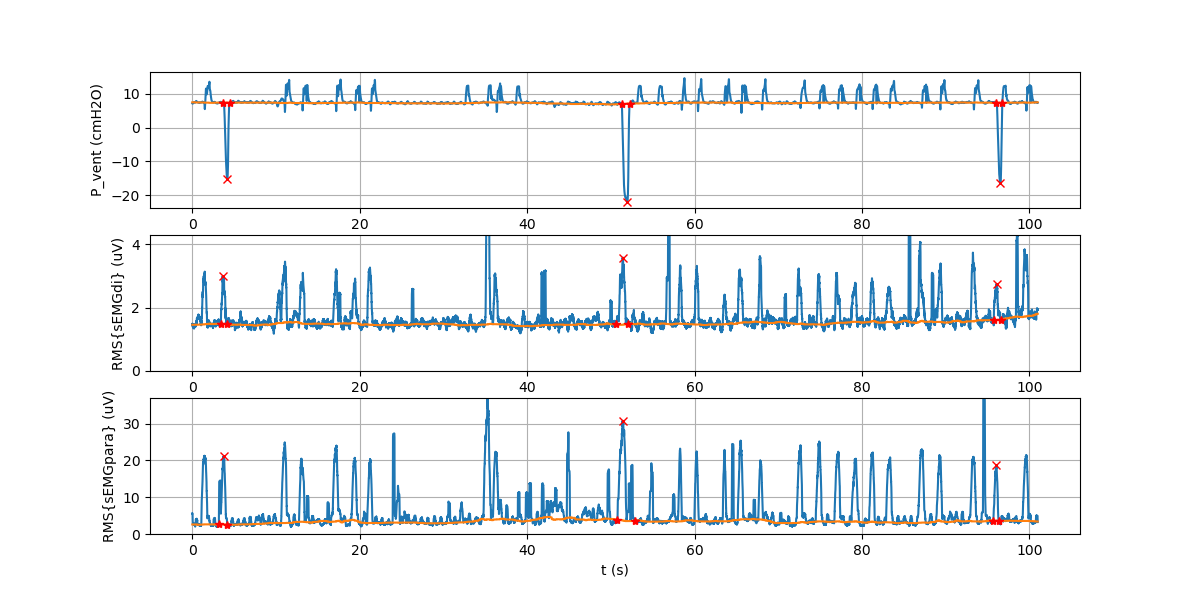

In [41]:
# Plot entire selected time window with indicated peaks

fig_1, axis = plt.subplots(nrows=3, ncols=1, figsize=(12, 6))
axis[0].grid(True)
axis[0].plot([y / draeger_sample_rate for y in range(len(x))], x)
axis[0].plot([y / draeger_sample_rate for y in range(len(x))],
             P_rolling_base_line)
axis[0].plot(P_occ_peaks/draeger_sample_rate, x[P_occ_peaks], "x", color="r")
axis[0].plot(P_occ_starts / draeger_sample_rate,
             P_rolling_base_line[P_occ_starts], '*r')
axis[0].plot(P_occ_ends / draeger_sample_rate,
             P_rolling_base_line[P_occ_ends], '*r')
axis[0].set_ylabel('P_vent (cmH2O)')

# Rolling baseline:
axis[1].grid(True)
N_samp = len(RMS_data_emg_di[int(start_s):int(end_s)])
axis[1].plot([y / emg_sample_rate for y in range(N_samp)],
             RMS_data_emg_di[int(start_s):int(end_s)])
axis[1].plot([y / emg_sample_rate for y in range(N_samp)],
             emg_di_rolling_base_line[:int(end_s)-int(start_s)])
axis[1].plot(EMG_di_occ_peaks/emg_sample_rate,
             y_di[EMG_di_occ_peaks], "x", color="r")
axis[1].plot(EMG_di_occ_starts / emg_sample_rate,
             emg_di_rolling_base_line[EMG_di_occ_starts], '*r')
axis[1].plot(EMG_di_occ_ends / emg_sample_rate,
             emg_di_rolling_base_line[EMG_di_occ_ends], '*r')
axis[1].set_ylabel('RMS{sEMGdi} (uV)')
axis[1].set_xlabel('t (s)')
axis[1].set_ylim([0, 1.2*max(y_di[EMG_di_occ_peaks])])


axis[2].grid(True)
axis[2].plot([y / emg_sample_rate for y in range(N_samp)],
             RMS_data_emg_para[int(start_s):int(end_s)])
axis[2].plot(EMG_para_occ_peaks/emg_sample_rate,
             y_para[EMG_para_occ_peaks], "x", color="r")

# Rolling baseline:
axis[2].plot([y / emg_sample_rate for y in range(N_samp)],
             emg_para_rolling_base_line[:int(end_s)-int(start_s)])
axis[2].plot(EMG_para_occ_starts / emg_sample_rate,
             emg_para_rolling_base_line[EMG_para_occ_starts], '*r')
axis[2].plot(EMG_para_occ_ends / emg_sample_rate,
             emg_para_rolling_base_line[EMG_para_occ_ends], '*r')
axis[2].set_ylabel('RMS{sEMGpara} (uV)')
axis[2].set_xlabel('t (s)')
axis[2].set_ylim([0, 1.2*max(y_para[EMG_para_occ_peaks])])

(array([ 7.93220617, 18.33831869,  9.33106558]),
 array([0.5753922 , 1.17856123, 0.4506289 ]),
 array([11.32179063, 28.01973325,  6.6081787 ]),
 array([13.7857382 , 15.55992025, 20.70676237]))

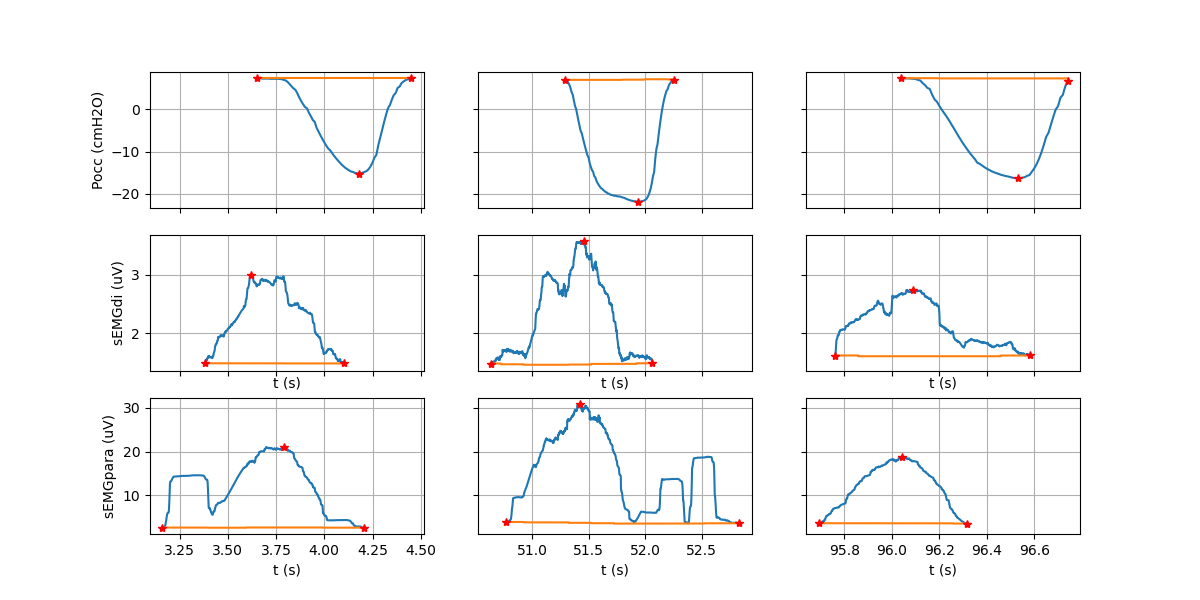

In [42]:
# Subplot per indicated peak
fig_2, axis = plt.subplots(nrows=3, ncols=len(
    P_occ_peaks), figsize=(12, 6), sharex='col', sharey='row')


PTP_occs = np.zeros((len(P_occ_peaks),))
for idx in range(len(P_occ_peaks)):
    start_i = P_occ_starts[idx]
    end_i = P_occ_ends[idx]
    axis[0, idx].grid(True)
    axis[0, idx].plot(y_draeger[start_i:end_i+1], x[start_i:end_i+1])
    axis[0, idx].plot(y_draeger[start_i:end_i+1],
                      P_rolling_base_line[start_i:end_i+1])

    axis[0, idx].plot(y_draeger[P_occ_peaks[idx]], x[P_occ_peaks[idx]], '*r')
    axis[0, idx].plot(y_draeger[start_i], x[start_i], '*r')
    axis[0, idx].plot(y_draeger[end_i], x[end_i], '*r')

    # Pressure Time Product (ETP) occlusion
    PTP_occs[idx] = np.abs(np.trapz(
        x[start_i:end_i+1]-P_rolling_base_line[start_i:end_i+1],
        dx=1/draeger_sample_rate
    ))

axis[0, 0].set_ylabel('Pocc (cmH2O)')

ETP_di_occs = np.zeros((len(EMG_di_occ_peaks),))
for idx in range(len(EMG_di_occ_peaks)):
    start_i = EMG_di_occ_starts[idx]
    end_i = EMG_di_occ_ends[idx]

    axis[1, idx].grid(True)
    axis[1, idx].plot(y_emg[start_i:end_i+1], y_di[start_i:end_i+1])
    axis[1, idx].plot(y_emg[start_i:end_i+1],
                      emg_di_rolling_base_line[start_i:end_i+1])
    axis[1, idx].plot(y_emg[EMG_di_occ_peaks[idx]],
                      y_di[EMG_di_occ_peaks[idx]], '*r')
    axis[1, idx].plot(y_emg[start_i], y_di[start_i], '*r')
    axis[1, idx].plot(y_emg[end_i], y_di[end_i], '*r')

    # EMG Time Product (ETP) diaphragm
    ETP_di_occs[idx] = np.trapz(
        y_di[start_i:end_i+1] - emg_di_rolling_base_line[start_i:end_i+1],
        dx=1/emg_sample_rate
    )

    axis[1, idx].set_xlabel('t (s)')

axis[1, 0].set_ylabel('sEMGdi (uV)')

ETP_para_occs = np.zeros((len(EMG_para_occ_peaks),))
for idx in range(len(EMG_para_occ_peaks)):
    start_i = EMG_para_occ_starts[idx]
    end_i = EMG_para_occ_ends[idx]

    axis[2, idx].grid(True)
    axis[2, idx].plot(y_emg[start_i:end_i+1], y_para[start_i:end_i+1])
    axis[2, idx].plot(y_emg[start_i:end_i+1],
                      emg_para_rolling_base_line[start_i:end_i+1])
    axis[2, idx].plot(y_emg[EMG_para_occ_peaks[idx]],
                      y_para[EMG_para_occ_peaks[idx]], '*r')
    axis[2, idx].plot(y_emg[start_i], y_para[start_i], '*r')
    axis[2, idx].plot(y_emg[end_i], y_para[end_i], '*r')

    # EMG Time Product (ETP) parasternal
    ETP_para_occs[idx] = np.trapz(
        y_para[start_i:end_i+1] - emg_di_rolling_base_line[start_i:end_i+1],
        dx=1/emg_sample_rate
    )

    axis[2, idx].set_xlabel('t (s)')

axis[2, 0].set_ylabel('sEMGpara (uV)')


# Calculated neuromuscular efficiency: NME = PTP / ETP_di
NME_di = np.abs(PTP_occs)/ETP_di_occs

PTP_occs, ETP_di_occs, ETP_para_occs, NME_di

Store values for later analysis

In [1]:
fig_1.savefig(main_output_dir + '/' + patient + '/' + measurements[date_idx] + '/' + measurements[date_idx] + '_' + patient + '_' + 
              measurement + '_timeplots_'+str(int(gate_width*1000))+'.png', dpi=300)
fig_2.savefig(main_output_dir + '/' + patient + '/' + measurements[date_idx]  + '/' + measurements[date_idx] + '_' + patient + '_' + 
              measurement + '_snapshots_'+str(int(gate_width*1000))+'.png', dpi=300)

for idx in range(len(PTP_occs)):
    data_now = [patient, measurement, PEEP_set, PTP_occs[idx],
                ETP_di_occs[idx], NME_di[idx], ETP_para_occs[idx]]
    big_data_list.append(data_now)


patient, measurement

NameError: name 'fig_1' is not defined

In [ ]:
big_data_list

[['MST001',
  '007',
  3.0,
  8.333939015284182,
  0.3748555472326203,
  22.232401459201224,
  7.282546261530575],
 ['MST001',
  '007',
  3.0,
  9.757024999007582,
  0.4886928338997486,
  19.96555775362394,
  7.920013169205741],
 ['MST001',
  '007',
  3.0,
  9.495127006322143,
  0.6389524170322309,
  14.860460267799843,
  7.2028011121408495],
 ['MST001',
  '008',
  5.0,
  8.645175189971924,
  0.43491502666328585,
  19.877848912921277,
  6.560196955116167],
 ['MST001',
  '008',
  5.0,
  7.982655068883301,
  0.3817826156534836,
  20.90890140510897,
  6.518353202579021],
 ['MST001',
  '008',
  5.0,
  8.116612495857478,
  0.574216522430038,
  14.135107888412247,
  5.973266492572829]]

In [ ]:
columns_now = ['patient', 'measurement', 'PEEP_set', 'PTP_occs', 'ETP_di_occs', 'NME_di', 'ETP_para_occs'
               ]
df = pd.DataFrame(big_data_list, columns=columns_now)
df

,patient,measurement,PEEP_set,PTP_occs,ETP_di_occs,NME_di,ETP_para_occs
0,MST001,007,3.0,8.333939,0.374856,22.232401,7.282546
1,MST001,007,3.0,9.757025,0.488693,19.965558,7.920013
2,MST001,007,3.0,9.495127,0.638952,14.860460,7.202801
3,MST001,008,5.0,8.645175,0.434915,19.877849,6.560197
4,MST001,008,5.0,7.982655,0.381783,20.908901,6.518353
5,MST001,008,5.0,8.116612,0.574217,14.135108,5.973266


Text(0.5, 1.0, '')

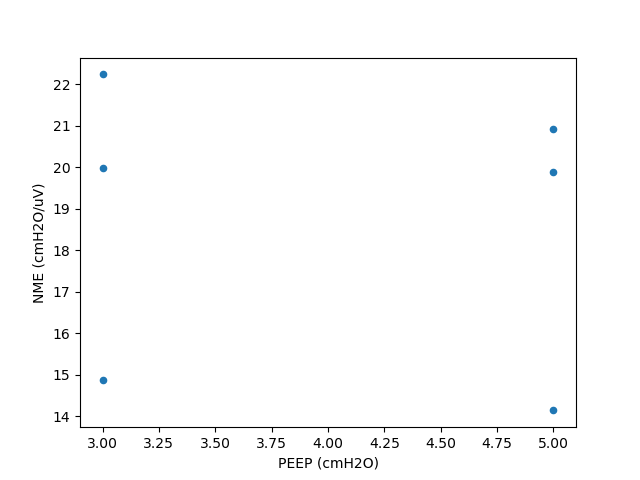

In [ ]:
bp = df.plot.scatter('PEEP_set', 'NME_di')
bp.set_ylabel('NME (cmH2O/uV)')
bp.set_xlabel('PEEP (cmH2O)')
bp.set_title('')

In [ ]:
context = patient + ' / ' + measurements[date_idx] + ' / ' + measurement + '\n' + \
'gate_width: ' + str(int(gate_width*1000)) + ' ms' + '\n' + \
'gate_threshold: ' + str(peak_fraction) + '' + '\n' + \
'gate_ECG_shift: ' + str(ECG_shift) + ' samples' + '\n' + \
'time_shift: ' + str(draeger_delay) + ' s' + '\n' + \
'Pocc_prominence_factor: ' + str(Pocc_prominence_factor) + '' + '\n' + \
'EMG_di_prominence_factor: ' + str(EMG_di_prominence_factor) + '' + '\n' + \
'EMG_para_prominence_factor: ' + str(EMG_para_prominence_factor) + '' + '\n' + \
'PEEP_set: ' + str(PEEP_set) + '' + '\n' + \
'analysis_date: ' + str(datetime.now())

with open(main_output_dir + '/' + patient + '/' + measurements[date_idx] + '/' + measurements[date_idx] + '_' + patient + '_' + measurement + '_readme.txt', 'w') as f:
    f.write(context)

In [ ]:
# Move on to the next measurement
measurement_idx += 1

['To next PEEP step'](#section_peep_step)

## Run these cells when all measurements for a data are analysed

In [242]:
df.to_csv(main_output_dir + '/' + patient + '/' + measurements[date_idx]  + '/' + measurements[date_idx] + '_' + patient +
          '_NME_data_gate_'+str(int(gate_width*1000))+'.csv')
# bp.figure.savefig(main_output_dir + patient + '/' + patient + '_'+str(int(gate_width*1000))+'_boxplot.png', dpi=300)
bp.figure.savefig(main_output_dir + '/' + patient + '/' + measurements[date_idx]  + '/' + measurements[date_idx] + '_' + patient +
                  '_gate_'+str(int(gate_width*1000))+'_scatter.png', dpi=300)

In [243]:
# Move on to the next measurement date
date_idx += 1

['To next date step'](#section_date_step)

In [ ]:
# Move on to the next patient
patient_idx += 1